## <font color = 'purple'>Notebook 12: Recurrent Neural Networks (RNN)</font>

<font color = 'purple'>A Recurrent Neural Network (RNN) is a type of neural network designed for processing sequential data, such as time series, text, or speech. It uses loops to allow information to persist, enabling the network to maintain a memory of previous inputs to make better predictions or classifications in sequences.</font>

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving main_dataset.xlsx to main_dataset.xlsx


In [ ]:
# Libraries for data processing
import numpy as np
import pandas as pd

# Libraries for text processing and NLP
import nltk
from textblob import TextBlob

# Gensim library for topic modelling and text vectorisation
import gensim
from gensim import corpora
from gensim.utils import simple_preprocess

# Libraries for data visualisation
from wordcloud import WordCloud, STOPWORDS
import seaborn as sns
import matplotlib.pyplot as plt

# Miscellaneous imports
import re
import warnings
warnings.filterwarnings("ignore")

In [ ]:
df = pd.read_excel('main_dataset.xlsx')

print("Shape of the dataset:", df.shape)
print("Columns in the dataset:", df.columns)

df.head()

Shape of the dataset: (44855, 4)
Columns in the dataset: Index(['date', 'review', 'rating', 'userName'], dtype='object')


,date,review,rating,userName
0,2021-05-06 05:15:00.000,This feature has been one of the most annoying...,5,Keanu De Sousa
1,2024-02-01 09:06:59.904,"The privacy on WhatsApp is incredible, I know ...",4,The great idea!!!
2,2023-08-14 05:42:00.000,"Hi WhatsApp,\nThis app is really great, I use ...",4,Pokey Ball ‚öæÔ∏è
3,2024-08-04 15:53:00.384,If there was ever an equivalent of social serv...,1,Zenicero
4,2024-05-26 01:12:59.616,Im on holiday and reliant on whatsapp to commu...,1,JohnDoe63737286


In [ ]:
import nltk
from nltk.corpus import stopwords

# Download stopwords if you haven't already
nltk.download('stopwords')

# Set of stopwords in English
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    if pd.isna(text) or not isinstance(text, str):
        return ""

    # Convert text to lowercase
    text = text.lower()

    # Remove punctuation and numbers
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)

    # Split text into words and remove stopwords
    words = text.split()
    filtered_words = [word for word in words if word not in stop_words]

    # Join the filtered words back into a single string
    cleaned_text = ' '.join(filtered_words)

    return cleaned_text

# Apply the updated preprocess_text function to your dataset
df['content_cleaned'] = df['review'].apply(preprocess_text)

# Display the first few rows of the cleaned content
df.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,date,review,rating,userName,content_cleaned
0,2021-05-06 05:15:00.000,This feature has been one of the most annoying...,5,Keanu De Sousa,feature one annoying aspects whatsapp everytim...
1,2024-02-01 09:06:59.904,"The privacy on WhatsApp is incredible, I know ...",4,The great idea!!!,privacy whatsapp incredible know probably donä...
2,2023-08-14 05:42:00.000,"Hi WhatsApp,\nThis app is really great, I use ...",4,Pokey Ball ‚öæÔ∏è,hi whatsapp app really great use everyday exac...
3,2024-08-04 15:53:00.384,If there was ever an equivalent of social serv...,1,Zenicero,ever equivalent social services took words awa...
4,2024-05-26 01:12:59.616,Im on holiday and reliant on whatsapp to commu...,1,JohnDoe63737286,im holiday reliant whatsapp communicate agents...


In [ ]:
df.isnull()
total_null_values = df.isnull().sum().sum()
print("Total null values in the DataFrame: ", total_null_values)
df.fillna('', inplace = True)
df['date'] = pd.to_datetime(df['date'], dayfirst = True)
df = df[['content_cleaned', 'review', 'rating', 'date']]
df.head()

Total null values in the DataFrame:  12


,content_cleaned,review,rating,date
0,feature one annoying aspects whatsapp everytim...,This feature has been one of the most annoying...,5,2021-05-06 05:15:00.000
1,privacy whatsapp incredible know probably donä...,"The privacy on WhatsApp is incredible, I know ...",4,2024-02-01 09:06:59.904
2,hi whatsapp app really great use everyday exac...,"Hi WhatsApp,\nThis app is really great, I use ...",4,2023-08-14 05:42:00.000
3,ever equivalent social services took words awa...,If there was ever an equivalent of social serv...,1,2024-08-04 15:53:00.384
4,im holiday reliant whatsapp communicate agents...,Im on holiday and reliant on whatsapp to commu...,1,2024-05-26 01:12:59.616


In [ ]:
def get_sentiment(text):
    return TextBlob(text).sentiment.polarity

df['sentiment'] = df['content_cleaned'].apply(get_sentiment)
df['sentiment_label'] = df['sentiment'].apply(lambda x: 'positive' if x > 0.1 else
                                             ('negative' if x <- 0.1 else 'neutral'))

In [ ]:
df[['content_cleaned', 'rating', 'sentiment_label']]

,content_cleaned,rating,sentiment_label
0,feature one annoying aspects whatsapp everytim...,5,negative
1,privacy whatsapp incredible know probably donä...,4,positive
2,hi whatsapp app really great use everyday exac...,4,positive
3,ever equivalent social services took words awa...,1,positive
4,im holiday reliant whatsapp communicate agents...,1,negative
...,...,...,...
44850,free delivery prime,5,positive
44851,would expectamazon trying get hand pocket,3,neutral
44852,registry system mess sorting price low high wa...,2,neutral
44853,clothes furniture options kinda meh overall de...,3,neutral


In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout

In [ ]:
# Tokenizer for converting text to sequences
max_words = 10000 # Max words in vocabulary
max_len = 200 # Max sequence length

tokenizer = Tokenizer(num_words = max_words)
tokenizer.fit_on_texts(df['content_cleaned'])

In [ ]:
sequences = tokenizer.texts_to_sequences(df['content_cleaned'])
X = pad_sequences(sequences, maxlen = max_len)

In [ ]:
df['sentiment_label_num'] = df['sentiment_label'].apply(lambda x: 1 if x == 'positive' else (0 if x == 'negative' else 2))
y = pd.get_dummies(df['sentiment_label_num']).values

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# Build the RNN Model
model = Sequential()
model.add(Embedding(input_dim = max_words, output_dim = 64, input_length = max_len))
model.add(SimpleRNN(units = 128, return_sequences = False))
model.add(Dropout(0.5))
model.add(Dense(3, activation = 'softmax'))

model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
model.summary()

# Train the Model
history = model.fit(X_train, y_train, epochs=5, batch_size=64, validation_split=0.2)

# Evaluate the Model
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_acc}')

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_1 (SimpleRNN)             │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
449/449 ━━━━━━━━━━━━━━━━━━━━ 51s 107ms/step - accuracy: 0.6716 - loss: 0.7086 - val_accuracy: 0.8874 - val_loss: 0.2973
Epoch 2/5
449/449 ━━━━━━━━━━━━━━━━━━━━ 48s 108ms/step - accuracy: 0.8705 - loss: 0.3507 - val_accuracy: 0.8881 - val_loss: 0.3203
Epoch 3/5
449/449 ━━━━━━━━━━━━━━━━━━━━ 46s 103ms/step - accuracy: 0.9156 - loss: 0.2440 - val_accuracy: 0.9206 - val_loss: 0.2350
Epoch 4/5
449/449 ━━━━━━━━━━━━━━━━━━━━ 82s 103ms/step - accuracy: 0.9583 - loss: 0.1332 - val_accuracy: 0.9398 - val_loss: 0.1996
Epoch 5/5
449/449 ━━━━━━━━━━━━━━━━━━━━ 83s 106ms/step - accuracy: 0.9714 - loss: 0.0871 - val_accuracy: 0.9447 - val_loss: 0.1950
281/281 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.9440 - loss: 0.1965
Test Accuracy: 0.9462713003158569


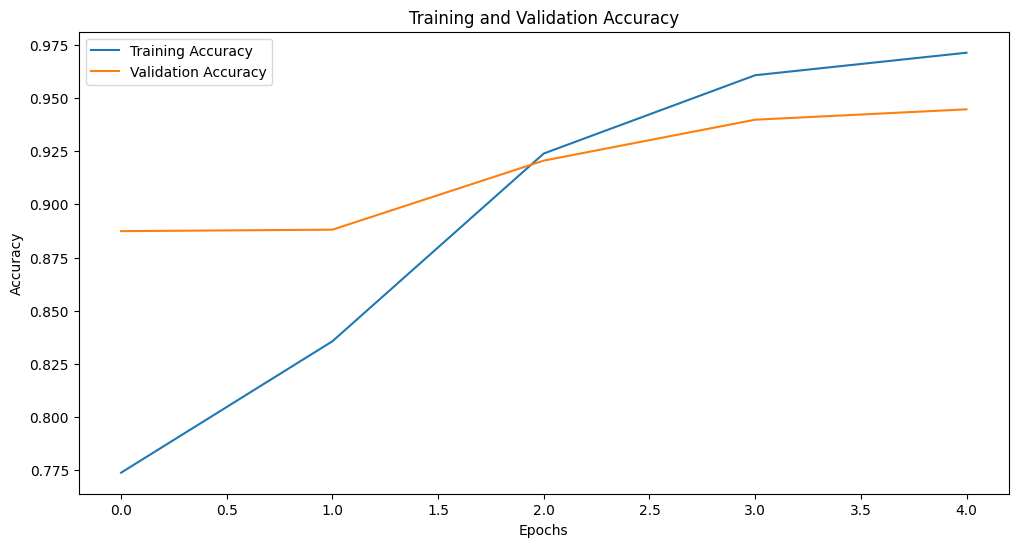

In [ ]:
# Plot Training and Validation Accuracy
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

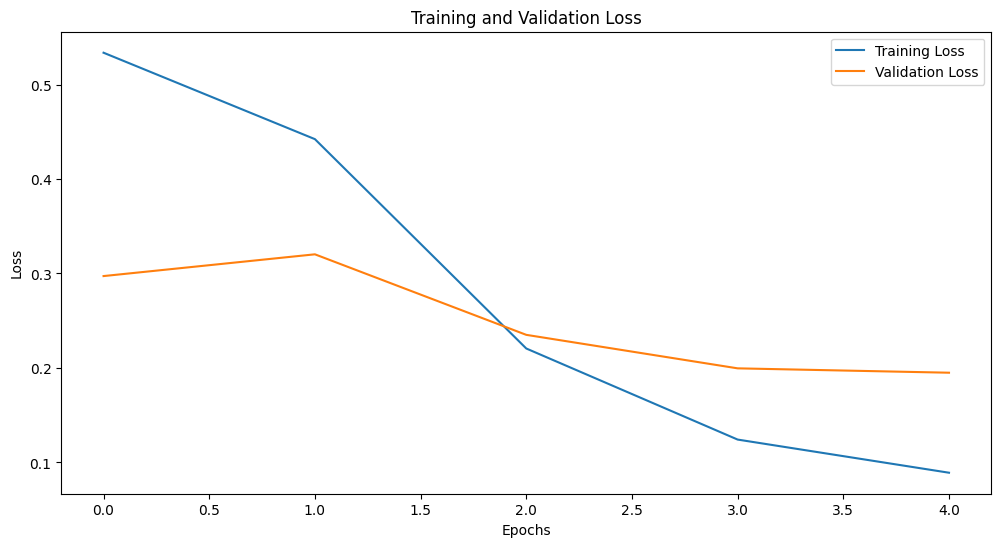

In [ ]:
# Plot Training and Validation Loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
#pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 9.7 MB/s eta 0:00:00
